In [1]:
import pandas as pd
import geopandas as gpd
import uuid
import matplotlib.pyplot as plt
import re
from math import ceil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from shapely import wkt
import os
import ast
import hashlib

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

---
# <b>1. Create synthesized PFT table<b>

In [2]:
# rename columns for ESS-Dive
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

# throughout the script this will help keep my indices matching
def normalize_to_int_str(val):
    try:
        f = float(val)
        i = int(f)
        if f == i:
            return str(i)
    except (ValueError, TypeError):
        # now also catches the int(inf) case
        pass
    return str(val)

# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
pft_dfs = []
for src in sources:
    df = pd.read_csv(f'{src}/output_data/{src}_standard_pft_fcover.csv',
                     index_col=0, encoding='utf-8-sig')
    df.columns = [camel_to_snake(c) for c in df.columns]
    df.index.name = 'visit_id'
    pft_dfs.append(df)

# adjust column names and index
pft_fcover = pd.concat(pft_dfs)

In [4]:
pft_fcover.head(3)

,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,bareground_cover,water_cover,other_cover
visit_id,,,,,,,,,,,,,
u580f8d998,17.440001,NaN,24.83,NaN,9.390000,14.770000,28.83,22.120001,6.71,75.169998,0.67,3.36,NaN
u7237c5455,47.720001,NaN,NaN,NaN,40.279999,56.049999,39.68,39.680000,NaN,79.370003,1.59,0.00,NaN
u5a8ac1d8b,40.660000,NaN,NaN,NaN,21.340000,20.010000,24.67,24.670000,NaN,79.330002,6.00,0.00,NaN


---
# 2. Create synthesized plot information (aux) table

## 2.a. Concatenate individual plot info tables

In [6]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
aux_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_plot_info.csv'
    df = pd.read_csv(path, index_col=0)
    
    # normalize index right away
    df.index.name = 'visit_id'
    df.columns = [camel_to_snake(col) for col in df.columns]
    
    # set integer columns (after renaming)
    intcols = ['survey_year', 'survey_month', 'survey_day']
    for col in intcols:
        df[col] = df[col].astype('Int64')
    
    aux_dfs.append(df)

# combine all plot data
aux = pd.concat(aux_dfs)

# drop data collected before 2010
aux = aux[aux['survey_year'] >= 2010]

# join aux to pft_fcover by visit_id
subset_pft_fcover = pft_fcover.loc[aux.index]
subset_pft_fcover

,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,bareground_cover,water_cover,other_cover
visit_id,,,,,,,,,,,,,
u580f8d998,17.440001,NaN,24.83,NaN,9.390000,14.770000,28.83,22.120001,6.71,75.169998,0.670000,3.36,NaN
u7237c5455,47.720001,NaN,NaN,NaN,40.279999,56.049999,39.68,39.680000,NaN,79.370003,1.590000,0.00,NaN
u5a8ac1d8b,40.660000,NaN,NaN,NaN,21.340000,20.010000,24.67,24.670000,NaN,79.330002,6.000000,0.00,NaN
u59bc4b4ea,14.290000,NaN,NaN,NaN,8.530000,1.690000,0.00,NaN,NaN,9.520000,76.190002,0.00,1.59
u28d3422f0,8.240000,NaN,NaN,NaN,19.459999,8.240000,0.40,0.400000,NaN,22.219999,55.560001,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ubed4eb698,96.000000,NaN,55.00,NaN,0.500000,69.000000,9.00,6.500000,2.50,0.000000,4.000000,0.00,NaN
u8c1017982,59.000000,NaN,27.00,NaN,3.000000,30.000000,14.50,10.500000,4.00,0.000000,0.000000,0.00,NaN
u07dcd3715,15.000000,NaN,43.00,NaN,5.000000,88.000000,8.50,7.500000,1.00,0.000000,0.000000,0.00,NaN


In [7]:
##### Get subselection for manuscript ######
pft_fcover = subset_pft_fcover

In [8]:
# export pft_fcover
pft_fcover = pft_fcover.replace({None: np.nan, '':np.nan})
pft_fcover.to_csv('synthesized_pft_fcover.csv', index=True, encoding='utf-8-sig')

# export aux
aux.to_csv('etc/survey_unit_information_temp.csv', encoding='utf-8-sig')

## 2.b. Fill in missing plot information variables manually
Save as `survey_unit_information.csv` in main directory
- Manual assessment because some rows missing admin_unit, admin_country, bioclim_subzone

## 2.c. Summarize final plot information table

#### Columns

In [9]:
# ensure encoding is correct
aux = pd.read_csv('survey_unit_information.csv')
aux.to_csv('survey_unit_information.csv', encoding='utf-8-sig', index=False)
aux = pd.read_csv('survey_unit_information.csv')

In [10]:
aux.columns

Index(['visit_id', 'survey_year', 'survey_month', 'survey_day', 'plot_area',
       'plot_shape', 'latitude_y', 'longitude_x', 'georef_source',
       'georef_accuracy', 'coord_epsg', 'plot_name', 'data_subsource',
       'data_source', 'data_source_html', 'data_subsource_citation',
       'survey_method', 'fcover_scale', 'survey_purpose', 'admin_unit',
       'admin_country', 'fire_years', 'bioclim_subzone', 'duplicated_coords',
       'duplicated_date', 'geometry'],
      dtype='object')

#### Plot counts per data subsource

In [11]:
len(aux['visit_id'].unique())

976

In [12]:
aux.groupby('data_subsource').count()['visit_id']

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    184
Atqasuk Villarreal (pub 2013)                     31
Barrow DOE NGEE Sloan (pub 2014)                  48
Barrow IBP Tundra Biome Villarreal (pub 2012)     33
Flux Tower Zona Davidson (pub 2016)              140
NGEE-Arctic Amy Breen (pub 2020)                  97
Prudhoe ArcSEES road study Walker (pub 2015)      29
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     27
Shell Onshore Macander (pub 2017)                107
Toolik Field Station NEON (pub 2021)              84
Utqiagvik-Barrow NEON (pub 2021)                 196
Name: visit_id, dtype: int64

#### Plot collection date ranges

In [13]:
# Filter out rows where 'survey_year' is missing
aux_temp = aux.dropna(subset=['survey_year']).copy()

# Create a new date column from year, month, and day, explicitly naming the columns
aux_temp['date'] = pd.to_datetime(aux_temp[['survey_year', 'survey_month', 'survey_day']].rename(columns={
    'survey_year': 'year', 
    'survey_month': 'month', 
    'survey_day': 'day'
}), errors='coerce')

# Find the oldest date, skipping invalid dates
oldest_date = aux_temp['date'].min()
most_recent_date = aux_temp['date'].max()

print("Oldest date:", oldest_date)
print("Most resecent date:", most_recent_date)

Oldest date: 2010-08-01 00:00:00
Most resecent date: 2021-08-07 00:00:00


In [14]:
# Extract year from the 'date' column
min_max_years = aux_temp.groupby('data_subsource')['survey_year'].agg(['min', 'max']).reset_index()
min_max_years

,data_subsource,min,max
0,AIM NPR-A Nawrocki (pub 2020),2012,2017
1,Atqasuk Villarreal (pub 2013),2010,2010
2,Barrow DOE NGEE Sloan (pub 2014),2012,2012
3,Barrow IBP Tundra Biome Villarreal (pub 2012),2010,2010
4,Flux Tower Zona Davidson (pub 2016),2014,2014
5,NGEE-Arctic Amy Breen (pub 2020),2016,2018
6,Prudhoe ArcSEES road study Walker (pub 2015),2014,2014
7,Prudhoe Bay Airport ArcSEES Walker (pub 2016),2015,2015
8,Shell Onshore Macander (pub 2017),2012,2012
9,Toolik Field Station NEON (pub 2021),2021,2021


#### Spatial bounds of all plots

In [15]:
# Copy the original dataframe
aux_temp = aux.copy()

# Create the GeoDataFrame by converting longitude and latitude to geometry
aux_gdf = gpd.GeoDataFrame(aux_temp, geometry=gpd.points_from_xy(aux_temp['longitude_x'], aux_temp['latitude_y']))

# Get the bounding box coordinates
bounding_box = aux_gdf.total_bounds
minx, miny, maxx, maxy = bounding_box

# Bounding coordinates for ESS-Dive
northwest = (maxy, minx)  # (latitude, longitude) for northwest
southeast = (miny, maxx)  # (latitude, longitude) for southeast

print("Northwest (lat, lon):", northwest)
print("Southeast (lat, lon):", southeast)

Northwest (lat, lon): (71.32504, -165.97109)
Southeast (lat, lon): (64.7278975, -148.422128)


#### Average plot sizes per subsource

In [16]:
aux.groupby(['survey_method'])['plot_area'].agg(['mean', 'count', 'sum', 'min', 'max'])

,mean,count,sum,min,max
survey_method,,,,,
center-staked point-intercept along transect,5328.022386,291,1.550455e+06,2827.433388,9503.317777
plot along transect,1.000000,168,1.680000e+02,1.000000,1.000000
simple plot,2.160621,517,1.117041e+03,1.000000,19.634954


In [17]:
aux.groupby(['data_source', 'plot_shape'])['plot_area'].agg(['mean', 'count', 'sum', 'min', 'max'])

mean  count           sum  \
data_source plot_shape                                              
ABR         circle               9503.317777    107  1.016855e+06   
AKVEG       circle               2899.997349    184  5.335995e+05   
AVA         irregular               1.000000     13  1.300000e+01   
            linear/band-forming     1.000000     51  5.100000e+01   
            square                  1.000000    244  2.440000e+02   
NEON        square                  1.000000    280  2.800000e+02   
NGA         circle                  7.185988     97  6.970409e+02   

                                         min          max  
data_source plot_shape                                     
ABR         circle               9503.317777  9503.317777  
AKVEG       circle               2827.433388  9503.317777  
AVA         irregular               1.000000     1.000000  
            linear/band-forming     1.000000     1.000000  
            square                  1.000000     1.000000  
NEON        square                  1.000000     1.000000  
NGA         circle                  4.908739    19.634954

## 3. Plot PFT distribution

In [18]:
# Initialize the MinMaxScaler with the desired feature range
# scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
cover_cols = [col for col in pft_fcover.columns if 'cover' in col]
# pft_fcover_scaled = pd.DataFrame(scaler.fit_transform(pft_fcover[cover_cols]), columns=cover_cols)
pft_fcover_scaled = pd.DataFrame(pft_fcover[cover_cols], columns=cover_cols)

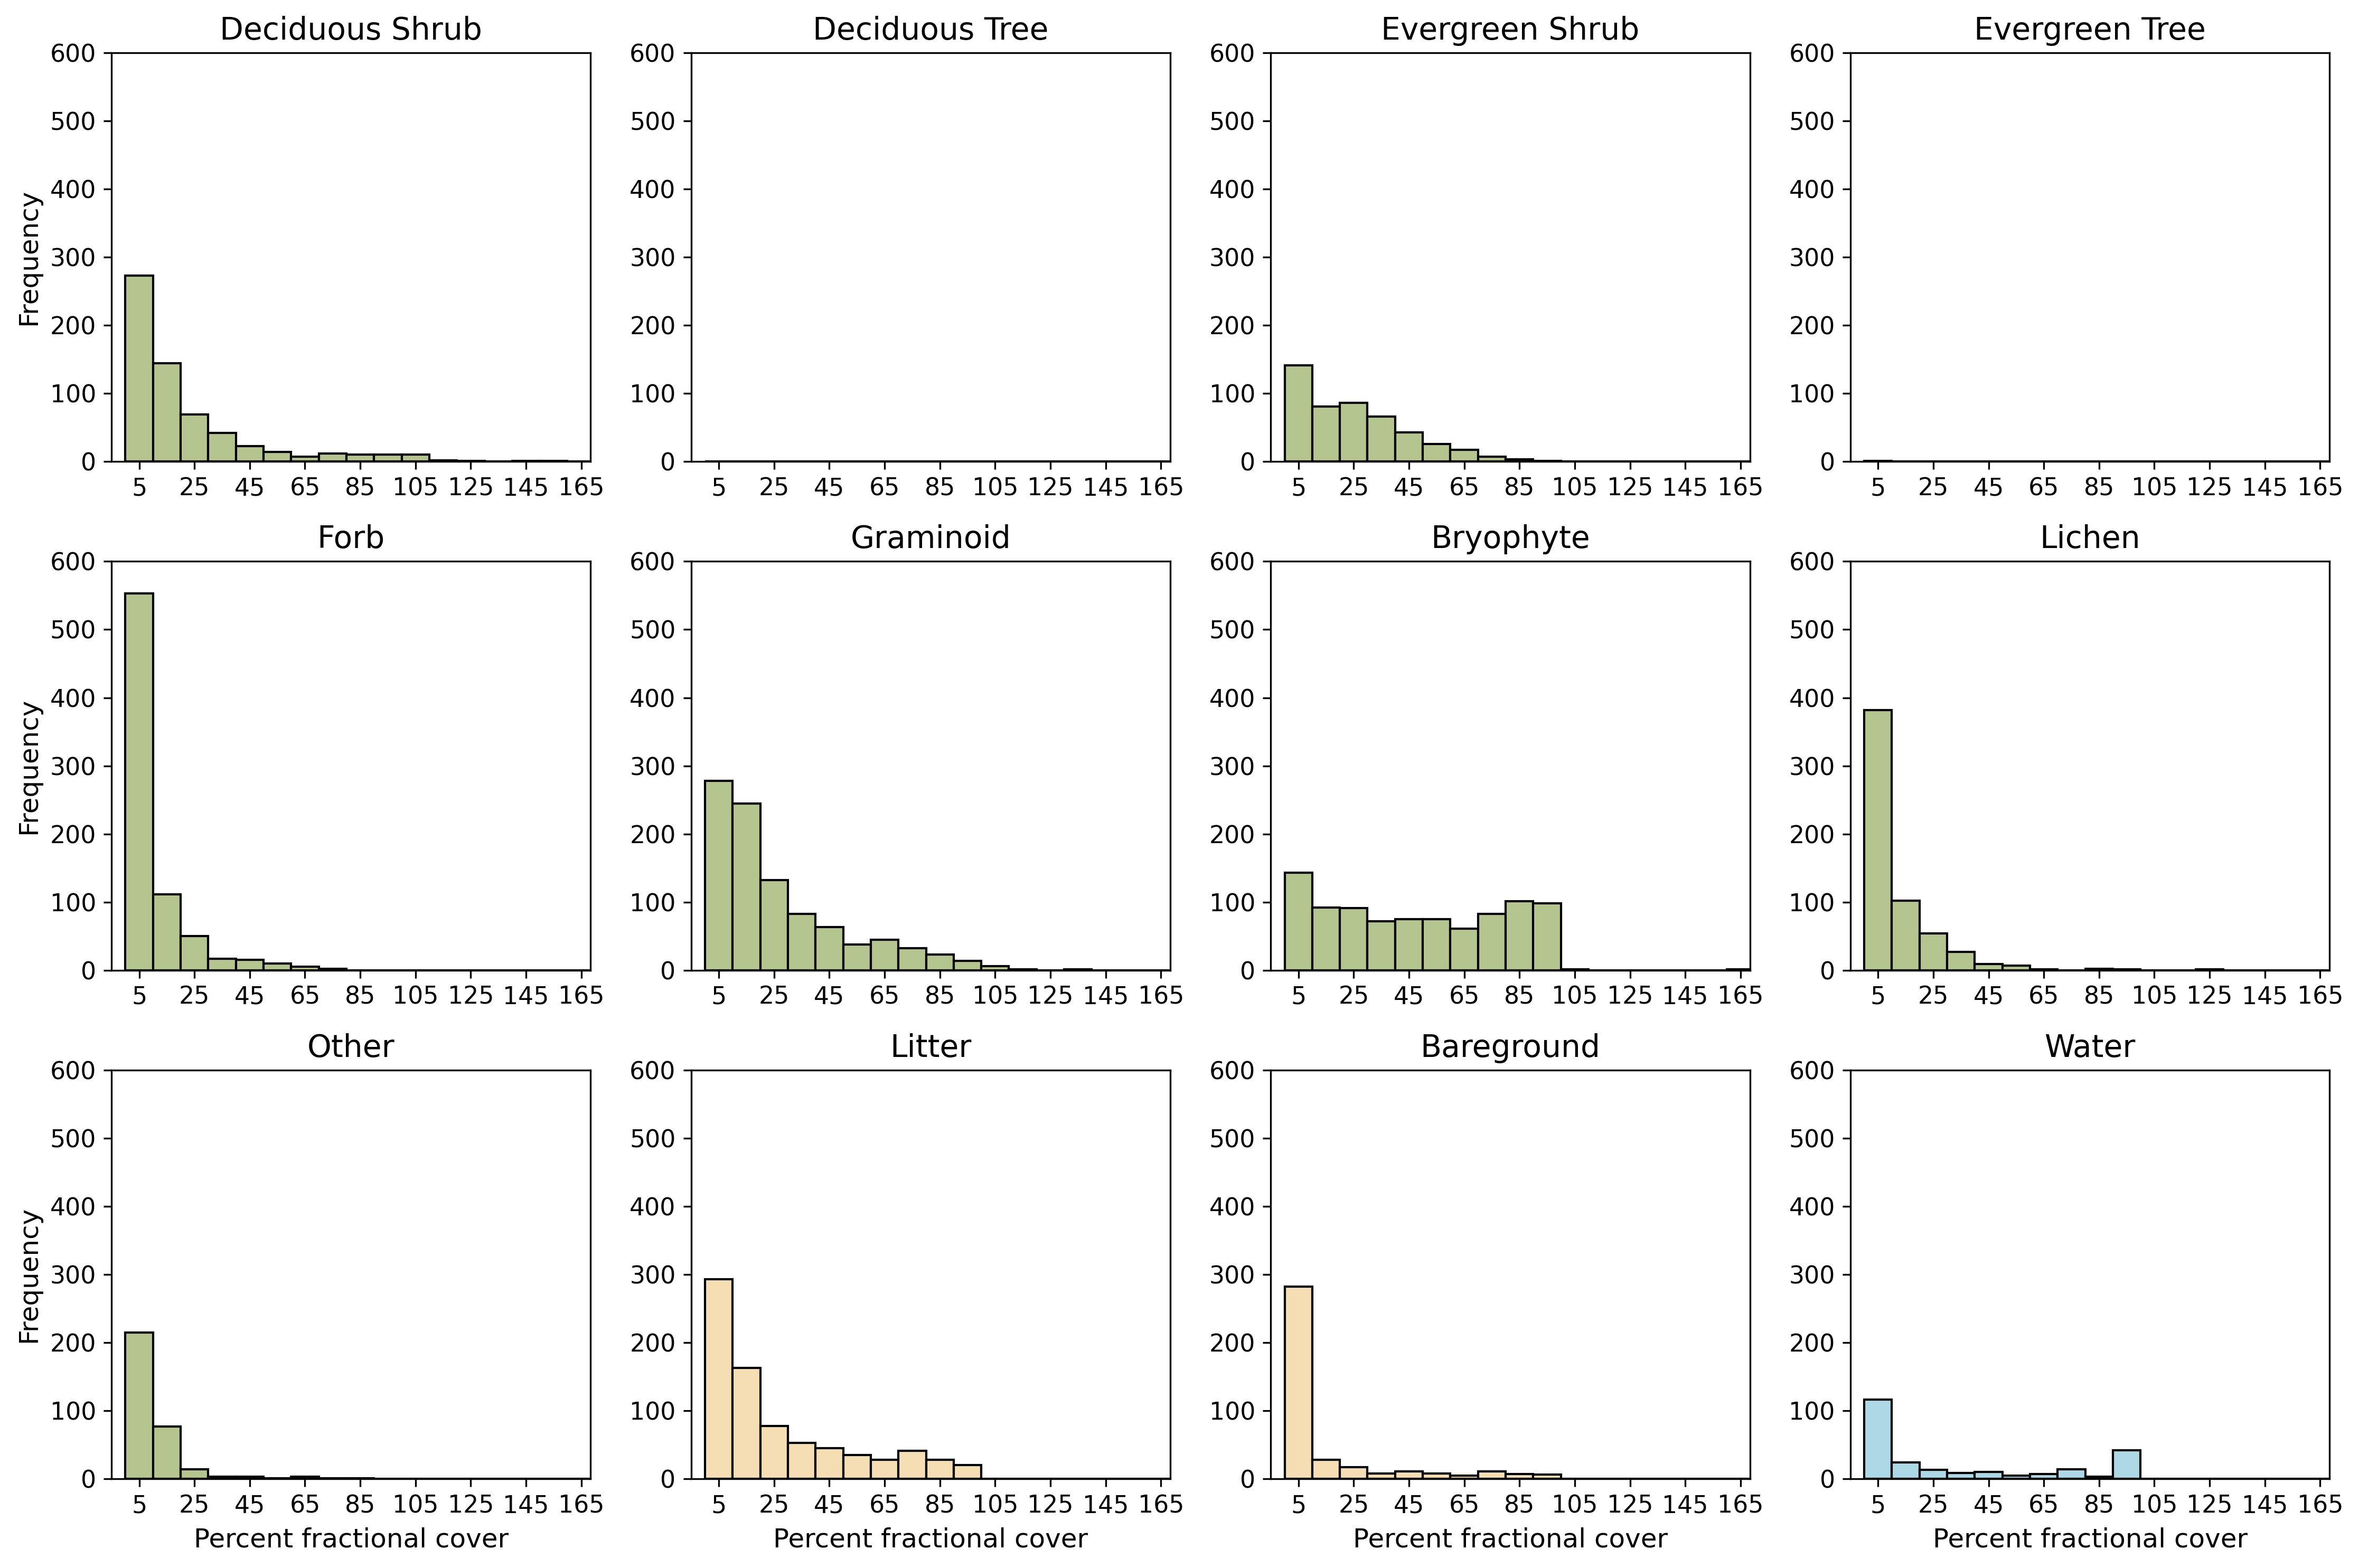

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# List of fcover types
fcover_types = ['deciduous_shrub_cover', 'deciduous_tree_cover', 'evergreen_shrub_cover', 'evergreen_tree_cover',
                'forb_cover', 'graminoid_cover', 'bryophyte_cover', 'lichen_cover',
                'other_cover', 'litter_cover', 'bareground_cover', 'water_cover']

# Number of subplots
num_subplots = len(fcover_types)
nrows = 3
ncols = ceil(num_subplots / nrows)

# Determine common x and y ranges, excluding zeros
all_values_nonzero = pd.concat([pft_fcover_scaled[col][pft_fcover_scaled[col] > 0].dropna() for col in fcover_types])
x_min_nonzero, x_max = all_values_nonzero.min(), all_values_nonzero.max()

# Create a figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Define bin edges, excluding 0
bin_width = 10
bin_edges = np.arange(x_min_nonzero, x_max + bin_width, bin_width)

# Y-axis limits and colors
y_axis_limits = {
    'Deciduous Shrub': (1000, '#b5c58f'),
    'Deciduous Tree': (1000, '#b5c58f'),
    'Evergreen Shrub': (1000, '#b5c58f'),
    'Evergreen Tree': (1000, '#b5c58f'),
    'Forb': (1000, '#b5c58f'),
    'Graminoid': (1000, '#b5c58f'),
    'Bryophyte': (1000, '#b5c58f'),
    'Lichen': (1000, '#b5c58f'),
    'Litter': (1000, 'wheat'),
    'Other': (1000, '#b5c58f'),
    'Water': (1000, 'lightblue'),
    'Bareground': (1000, 'wheat')
}

# Format fcover titles
def format_fcover_title(fcover_type):
    return fcover_type.replace('_cover', '').replace('_', ' ').title()

# Plot each fcover type
for i, fcover_type in enumerate(fcover_types):
    title = format_fcover_title(fcover_type)
    y_limit, color = y_axis_limits.get(title, (40, 'lightgray'))  

    # Filter data to exclude zeros
    data_nonzero = pft_fcover[fcover_type][pft_fcover[fcover_type] > 0].dropna()
    
    # Generate histogram with align='mid' to prevent cutoff
    n, bins, patches = axs[i].hist(
        data_nonzero, 
        bins=bin_edges, 
        color=color, 
        edgecolor='black', 
        align='mid'  # Center bin values
    )

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Set x-ticks at bin centers
    tick_spacing = 2
    axs[i].set_xticks(bin_centers[::tick_spacing])
    axs[i].set_xticklabels([f"{int(center)}" for center in bin_centers[::tick_spacing]])
    
    axs[i].set_title(title, fontsize=14)
    
    # Adjust x-axis limits to prevent leftmost cutoff
    axs[i].set_xlim(x_min_nonzero - bin_width / 2, x_max + bin_width / 2)  

    axs[i].set_ylim(0, 600)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    
    # Set x-axis label only for the bottom row
    if i >= (nrows - 1) * ncols:
        axs[i].set_xlabel('Percent fractional cover', fontsize=12)
    
    # Set y-axis label only for the far-left column
    if i % ncols == 0:
        axs[i].set_ylabel('Frequency', fontsize=12)

# Remove empty subplots
for j in range(num_subplots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]

,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,bareground_cover,water_cover,other_cover
visit_id,,,,,,,,,,,,,
u580f8d998,17.440001,NaN,24.83,NaN,9.390000,14.770000,28.83,22.120001,6.71,75.169998,0.670000,3.36,NaN
u7237c5455,47.720001,NaN,NaN,NaN,40.279999,56.049999,39.68,39.680000,NaN,79.370003,1.590000,0.00,NaN
u5a8ac1d8b,40.660000,NaN,NaN,NaN,21.340000,20.010000,24.67,24.670000,NaN,79.330002,6.000000,0.00,NaN
u59bc4b4ea,14.290000,NaN,NaN,NaN,8.530000,1.690000,0.00,NaN,NaN,9.520000,76.190002,0.00,1.59
u28d3422f0,8.240000,NaN,NaN,NaN,19.459999,8.240000,0.40,0.400000,NaN,22.219999,55.560001,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ubed4eb698,96.000000,NaN,55.00,NaN,0.500000,69.000000,9.00,6.500000,2.50,0.000000,4.000000,0.00,NaN
u8c1017982,59.000000,NaN,27.00,NaN,3.000000,30.000000,14.50,10.500000,4.00,0.000000,0.000000,0.00,NaN
u07dcd3715,15.000000,NaN,43.00,NaN,5.000000,88.000000,8.50,7.500000,1.00,0.000000,0.000000,0.00,NaN


In [21]:
plots_w_other = len(pft_fcover_scaled[(pft_fcover_scaled['other_cover'] != 0) & (~pft_fcover_scaled['other_cover'].isna())]) / len(pft_fcover_scaled)
print('Percent of plots containing "other" cover:', round(plots_w_other * 100, 2))

Percent of plots containing "other" cover: 32.58


In [22]:
# Count how many "other_cover" values are nonzero and not NaN
other_nonzero = (pft_fcover_scaled['other_cover'].notnull() & (pft_fcover_scaled['other_cover'] != 0)).sum()

# Count total number of nonzero and non-NaN values across the entire DataFrame
total_nonzero_nonnull = (pft_fcover_scaled.notnull() & (pft_fcover_scaled != 0)).sum().sum()

# Calculate the percent
other_vals_per_total = other_nonzero / total_nonzero_nonnull
print('Percent of all non-zero cover that is "other" cover:', round(other_vals_per_total * 100, 2))

Percent of all non-zero cover that is "other" cover: 4.59


In [23]:
mask = (pft_fcover_scaled['other_cover'] != 0) & (pft_fcover_scaled['other_cover'].notna())
median_other_cover = pft_fcover_scaled.loc[mask, 'other_cover'].median()
median_other_cover

7.5

In [24]:
bioclimate_gdf = gpd.read_file("etc/bioclim/bioclimate_la_latlon.shp")
bioclimate_gdf

,zone,Shape_Leng,Shape_Area,geometry
0,0,2.046336e+07,1.697165e+12,"POLYGON ((-43.38132 60.11147, -43.37944 60.103..."
1,1,2.252616e+07,1.946250e+11,"MULTIPOLYGON (((107.75593 77.30695, 107.75288 ..."
2,2,4.693177e+07,5.116929e+11,"MULTIPOLYGON (((113.31934 75.63689, 113.31125 ..."
3,3,7.821926e+07,1.301256e+12,"MULTIPOLYGON (((171.18156 70.06726, 171.27397 ..."
4,4,8.420476e+07,1.576037e+12,"MULTIPOLYGON (((-172.24023 60.29866, -172.2485..."
5,5,6.435929e+07,1.841596e+12,"MULTIPOLYGON (((137.26956 71.57438, 137.28616 ..."
6,6,2.178417e+06,1.128100e+10,"MULTIPOLYGON (((-163.18776 65.00010, -163.1612..."


---
# 4. Create species to PFT checklist

In [25]:
def camel_to_snake(name):
    name = name.strip()
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub(r'([a-z0-9])([A-Z])',      r'\1_\2', name)
    return name.lower()

sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
species_dfs = []

for source in sources:
    path = f'{source}/output_data/{source}_nonstandard_species_fcover.csv'
    df = pd.read_csv(path, index_col=0)
    
    # normalize column names before concatenation
    df.columns = [camel_to_snake(col) for col in df.columns]
    
    # ensure the index (visit IDs) stays as string
    df.index.name = 'visit_id'
    
    species_dfs.append(df)

# concatenate with matching, snake_case columns
species_fcover = pd.concat(species_dfs, axis=0)

# rename only the columns that need changing
species_fcover = species_fcover.rename(columns={
    'standard_habit': 'pft',
    'nonstandard_habit': 'nonstandard_pft',
    'percent_cover': 'fcover'
})

print(len(species_fcover['dataset_species_name'].unique()))
species_fcover.head(3)

2242


,dataset_species_name,pft,nonstandard_pft,fcover
visit_id,,,,
u165edeef6,Litter,litter,litter,18.54
u165edeef6,Hylocomium splendens,bryophyte,moss,15.89
u165edeef6,Carex bigelowii,graminoid,graminoid,11.26


## 4a. Replace dataset_species_names adjudicated by an expert

In [26]:
# create replacement dictionary using adjudicated file
adj = pd.read_csv('etc/akveg_species_nomatches_adjudication.csv')
adj_dict = adj.set_index('dataset_species_name')['Timm_adjudicated'].to_dict()
species_fcover['dataset_species_name'] = species_fcover['dataset_species_name'].replace(adj_dict)

## 4b. Create list of possible_accepted_names per unique dataset_species_name

In [27]:
# load akveg checklist and wanted columns
checklist = pd.read_csv('etc/akveg_species_checklist.csv')
checklist = checklist[['Name', 'Accepted Name']]

# Extract the first two words for merging
species_fcover['species_key'] = species_fcover['dataset_species_name'].apply(lambda x: ' '.join(x.split()[:2]))
checklist['name_key'] = checklist['Name'].apply(lambda x: ' '.join(x.split()[:2]))

# Perform the left join
merged_df = pd.merge(
    species_fcover,
    checklist,
    left_on='species_key',
    right_on='name_key',
    how='left'
)

# Drop the temporary columns if desired
merged_df.drop(columns=['species_key', 'name_key'], inplace=True)
grouped_df = merged_df.groupby('dataset_species_name').agg({'Accepted Name': lambda x: set(x)}).reset_index()
grouped_df.rename(columns={'Accepted Name':'possible_accepted_names'}, inplace=True)

# Add missing columns
grouped_df['accepted_species_name'] = np.nan
grouped_df['naming_authority'] = np.nan
grouped_df.head(3)

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},NaN,NaN
1,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},NaN,NaN
2,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,NaN,NaN


In [28]:
# File path
file_path = 'etc/species_standardization_mapping.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Read the file
    temp = pd.read_csv(file_path, index_col=0)
    
    # Perform the join and update grouped_df as needed
    merged_df = pd.merge(left=grouped_df, right=temp, 
                         left_on='dataset_species_name', right_on='dataset_species_name', 
                         how='left', suffixes=('', '_temp'))
    merged_df['accepted_species_name'].fillna(merged_df['accepted_species_name_temp'], inplace=True)
    merged_df['naming_authority'].fillna(merged_df['naming_authority_temp'], inplace=True)

    # Drop only the temporary columns that exist
    temp_columns_to_drop = [col for col in merged_df.columns if col.endswith('_temp')]
    merged_df.drop(columns=temp_columns_to_drop, inplace=True)
    
    print("File exists and merge completed.")
else:
    print(f"File '{file_path}' does not exist. Skipping join operation.")
merged_df = merged_df.drop_duplicates(subset=['dataset_species_name'])
merged_df

File exists and merge completed.


/tmp/ipykernel_2422963/3273958619.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['accepted_species_name'].fillna(merged_df['accepted_species_name_temp'], inplace=True)
/tmp/ipykernel_2422963/3273958619.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Abietinella abietina (Hedw.) Fleisch.'
 'Acarospora schleicheri (Ach.) A. Massal.' 'Achillea L.' ... nan nan nan]' has dtype incompatible with float64, please explicitly cast t

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
1,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
2,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea L.,Panarctic Flora Project Checklist
3,Achillea millefolium,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium L.,Flora of North America
4,Achillea millefolium s. borealis,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
2209,scat,{nan},NaN,NaN
2210,soil,{nan},NaN,NaN
2211,standingDeadHerbaceous,{nan},NaN,NaN
2212,standingDeadWoody,{nan},NaN,NaN


In [29]:
# Add naming_authority if missing some
checklist = pd.read_csv('etc/akveg_species_checklist.csv')
merged_df2 = pd.merge(left=merged_df, right=checklist[['Accepted Name', 'Name Source']],
                      left_on='accepted_species_name', right_on='Accepted Name',
                      how='left', suffixes=['', '_checklist'])

# Fill NaN values in merged_df['naming_authority'] with non-NaN values from checklist
merged_df2['naming_authority'].fillna(merged_df2['Name Source'], inplace=True)

# Drop the temporary column from the merge
merged_df2.drop(columns=['Accepted Name', 'Name Source'], inplace=True)
merged_df2.drop_duplicates(subset=['dataset_species_name'], inplace=True)
merged_df2

/tmp/ipykernel_2422963/1942094574.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df2['naming_authority'].fillna(merged_df2['Name Source'], inplace=True)


,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
3,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
20,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea L.,Panarctic Flora Project Checklist
21,Achillea millefolium,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium L.,Flora of North America
59,Achillea millefolium s. borealis,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
8055,scat,{nan},NaN,NaN
8056,soil,{nan},NaN,NaN
8057,standingDeadHerbaceous,{nan},NaN,NaN
8058,standingDeadWoody,{nan},NaN,NaN


In [30]:
# Export
merged_df2.to_csv('etc/species_standardization_mapping_temp.csv', index=None, encoding='utf-8-sig')
merged_df2.head(3)

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
3,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
20,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea L.,Panarctic Flora Project Checklist


## 4c. Manually assign accepted_species in `etc/species_standardization_mapping_temp` and save as `species_standardization_mapping`

Should have the columns:
- dataset_species_name
- possible_accepted_names
- accepted_name
- naming_authority

## 4d. Load dataframe with manually assigned accepted_name and naming_authority
- If there were no possible_accepted_names, the user should manually assign the naming_authority they referenced when assigning an accepted_name
- If user chose from list of possible_accepted_names as the accepted_name, the naming_authority will be joined to the table later

In [31]:
# load species name dataframe with corresponding accepted names
standard_species_map = pd.read_csv('etc/species_standardization_mapping.csv')
standard_species_map

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{'Abietinella abietina (Hedw.) Fleisch.'},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
1,Acarospora schleicheri,{'Acarospora schleicheri (Ach.) A. Massal.'},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
2,Achillea lanulosa,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea L.,Panarctic Flora Project Checklist
3,Achillea millefolium,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium L.,Flora of North America
4,Achillea millefolium s. borealis,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
2285,soil,{nan},NaN,NaN
2286,standingDeadHerbaceous,{nan},NaN,NaN
2287,standingDeadWoody,{nan},NaN,NaN
2288,unknown,{nan},NaN,NaN


## 4e. Check to see if more species need to be added to `species_standardization_mapping.csv`

In [32]:
missing_species = grouped_df[~grouped_df['dataset_species_name'].isin(standard_species_map['dataset_species_name'])]
if len(missing_species) > 0:
    # export dataframe for editing
    print(f'There are {len(missing_species)} dataset_species_names that need to be assigned an accepted_name.')
    missing_species.to_csv('etc/species_standardization_mapping_temp_01.csv', encoding='utf-8-sig')
else:
    # export empty dataframe
    print('There are no missing species in species_standardization_mapping.')
    missing_species.to_csv('etc/species_standardization_mapping_temp_01.csv', encoding='utf-8-sig')

There are 170 dataset_species_names that need to be assigned an accepted_name.


## 4e(2). Manually assign accepted_names in `etc/species_standardization_mapping_temp_01.csv` and save as `etc/species_standardization_mapping_temp_02.csv`
Once accepted names have been assigned, add the missing species to species_standardization_mapping:

In [33]:
# add dataset_species_names to species_standardization_mapping if necessary
added_species = pd.read_csv('etc/species_standardization_mapping_temp_02.csv', index_col=0)
if len(added_species) < 0:
    added_species.rename(columns={'possible_accepted_names':'accepted_species_name'}, inplace=True)
    standard_species_map = pd.concat([standard_species_map, added_species])

# overwrite existing mapping file to ensure encoding
# standard_species_map.to_csv('etc/species_standardization_mapping.csv', index=None, encoding='utf-8-sig')

## 4f. Join PFT and other columns to dataset_species_name

In [34]:
standard_species_map

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{'Abietinella abietina (Hedw.) Fleisch.'},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
1,Acarospora schleicheri,{'Acarospora schleicheri (Ach.) A. Massal.'},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
2,Achillea lanulosa,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea L.,Panarctic Flora Project Checklist
3,Achillea millefolium,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium L.,Flora of North America
4,Achillea millefolium s. borealis,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
2285,soil,{nan},NaN,NaN
2286,standingDeadHerbaceous,{nan},NaN,NaN
2287,standingDeadWoody,{nan},NaN,NaN
2288,unknown,{nan},NaN,NaN


In [35]:
# bring your index into a column named 'visit_id'
species_fcover = species_fcover.reset_index().rename(columns={'index':'visit_id'})

# now merge on dataset_species_name, and visit_id stays as a column
fcover_w_accepted_names = pd.merge(
    left=species_fcover,
    right=standard_species_map,
    on='dataset_species_name',
    how='left'
)
fcover_w_accepted_names

,visit_id,dataset_species_name,pft,nonstandard_pft,fcover,species_key,possible_accepted_names,accepted_species_name,naming_authority
0,u165edeef6,Litter,litter,litter,18.54,Litter,{nan},NaN,NaN
1,u165edeef6,Hylocomium splendens,bryophyte,moss,15.89,Hylocomium splendens,{'Hylocomium splendens (Hedw.) Schimp.'},Hylocomium splendens (Hedw.) Schimp.,Flora of North America
2,u165edeef6,Carex bigelowii,graminoid,graminoid,11.26,Carex bigelowii,{'Carex bigelowii ssp. ensifolia (Turcz. ex Go...,Carex bigelowii Torr. ex Schwein.,Panarctic Flora Project Checklist
3,u165edeef6,Alnus fruticosa,deciduous shrub,shrub,10.60,Alnus fruticosa,{'Alnus alnobetula ssp. sinuata (Regel) Raus.'...,Alnus alnobetula ssp. fruticosa (Rupr.) Raus.,Greuter and von Raab-Straube 2011
4,u165edeef6,Vaccinium uliginosum,deciduous shrub,shrub,9.93,Vaccinium uliginosum,{'Vaccinium uliginosum L.'},Vaccinium uliginosum L.,Flora of North America
...,...,...,...,...,...,...,...,...,...
1223018,u7323a5431,Luzula parviflora,graminoid,graminoid,NaN,Luzula parviflora,{'Luzula parviflora ssp. parviflora (Ehrh.) De...,Luzula parviflora (Ehrh.) Desv.,Panarctic Flora Project Checklist
1223019,u7323a5431,bare soil,bare ground,bare soil,0.00,bare soil,NaN,NaN,NaN
1223020,u7323a5431,litter,litter,litter,0.00,litter,{nan},NaN,NaN
1223021,u7323a5431,bare rock,bare ground,bare rock,0.00,bare rock,NaN,NaN,NaN


In [36]:
# Group by 'dataset_species_name' and aggregate 'visit_id' into a list
species_pft_checklist = fcover_w_accepted_names.groupby('dataset_species_name').agg({
    'visit_id': lambda x: list(x.unique()),  # List of unique unit_id values
    'accepted_species_name': 'first',      # Take the first value
    'naming_authority': 'first',           # Take the first value
    'pft': 'first',                        # Take the first value
    'nonstandard_pft': 'first'             # Take the first value
}).reset_index()

# Reorganize columns
species_pft_checklist = species_pft_checklist[['visit_id', 'accepted_species_name', 'dataset_species_name', 'naming_authority', 'pft', 'nonstandard_pft']]
species_pft_checklist = species_pft_checklist.sort_values(['accepted_species_name'])
species_pft_checklist

,visit_id,accepted_species_name,dataset_species_name,naming_authority,pft,nonstandard_pft
0,"[ue971a0c9e, uaa73cfd9b, u35d95359b, uf0f69fc6...",Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,Flora of North America,bryophyte,moss
1,"[u3e41cd323, ud0ef714b4, u00dda602e, u5e173091...",Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,Consortium of Lichen Herbaria,lichen,lichen
2,"[u9ffbd5716, u0dd9597d7, u1b3577145, u35b471d5...",Achillea L.,Achillea lanulosa,Panarctic Flora Project Checklist,forb,forb
3,"[u49e08a9a1, ufba382ece, u7237c5455, u3cb166875]",Achillea millefolium L.,Achillea millefolium,Flora of North America,forb,forb
4,"[u107127013, u82fbbf5a8, uf1a2eff24, u8a5c95bc...",Achillea millefolium ssp. borealis (Bong.) Bre...,Achillea millefolium s. borealis,Panarctic Flora Project Checklist,forb,forb
...,...,...,...,...,...,...
2209,"[u222247c68, ueb12acedd, ud6e037029, ue6bc2c6d...",None,scat,None,bare ground,salt
2210,"[u13ba2fc65, u64b1d5d88, u7884ee1d3, ueee39fc5...",None,soil,None,bare ground,soil
2211,"[u222247c68, ufa67ec6c0, ueb12acedd, ud6e03702...",None,standingDeadHerbaceous,None,other,dead
2212,"[uc95487f9b, u886023ff6, u0b7809ddc, u26cce5d7...",None,standingDeadWoody,None,other,dead


In [37]:
# fcover_w_accepted_names = pd.merge(left=species_fcover, right=standard_species_map, 
#                                       left_on='dataset_species_name', right_on='dataset_species_name', 
#                                       how='left')
# species_pft_checklist = fcover_w_accepted_names.drop(columns=['fcover'])
# species_pft_checklist = species_pft_checklist.drop_duplicates('dataset_species_name')
# species_pft_checklist = species_pft_checklist.reset_index(drop=True)
# species_pft_checklist = species_pft_checklist[['unit_id', 'accepted_species_name', 'dataset_species_name', 'naming_authority', 'pft', 'nonstandard_pft']]
# species_pft_checklist = species_pft_checklist.sort_values(['accepted_species_name'])
# species_pft_checklist

## 4g. Add AKVEG Checklist columns

In [38]:
og_checklist = pd.read_csv('etc/akveg_species_checklist.csv')

# Perform the merge
merged_df = pd.merge(left=species_pft_checklist, 
                     right=og_checklist[['Accepted Name', 'Category', 'Habit', 'Level']],
                     left_on='accepted_species_name', 
                     right_on='Accepted Name', 
                     how='outer')

# Group by accepted_species_name and keep the additional columns
aggregated_df = merged_df.groupby(['dataset_species_name']).agg({
    'visit_id': 'first',
    'Category': lambda x: set(x.dropna()),  # Remove NaN values and aggregate to sets
    'Habit': lambda x: set(x.dropna()),
    'Level': 'first',
    'accepted_species_name': 'first',        # Keep the first occurrence
    'naming_authority': 'first',             # Keep the first occurrence
    'pft': 'first',                          # Keep the first occurrence
    'nonstandard_pft': 'first',
}).reset_index()

# View the final dataframe
aggregated_df = aggregated_df.rename(columns={'Category':'category', 
                                              'Habit':'habit',
                                              'Level':'taxon_rank'})
aggregated_df

,dataset_species_name,visit_id,category,habit,taxon_rank,accepted_species_name,naming_authority,pft,nonstandard_pft
0,Abietinella abietina,"[ue971a0c9e, uaa73cfd9b, u35d95359b, uf0f69fc6...",{moss},{moss},species,Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte,moss
1,Acarospora schleicheri,"[u3e41cd323, ud0ef714b4, u00dda602e, u5e173091...",{lichen},{lichen},species,Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen,lichen
2,Achillea lanulosa,"[u9ffbd5716, u0dd9597d7, u1b3577145, u35b471d5...",{eudicot},{forb},genus,Achillea L.,Panarctic Flora Project Checklist,forb,forb
3,Achillea millefolium,"[u49e08a9a1, ufba382ece, u7237c5455, u3cb166875]",{eudicot},{forb},species,Achillea millefolium L.,Flora of North America,forb,forb
4,Achillea millefolium s. borealis,"[u107127013, u82fbbf5a8, uf1a2eff24, u8a5c95bc...",{eudicot},{forb},subspecies,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist,forb,forb
...,...,...,...,...,...,...,...,...,...
2209,scat,"[u222247c68, ueb12acedd, ud6e037029, ue6bc2c6d...",{},{},None,None,None,bare ground,salt
2210,soil,"[u13ba2fc65, u64b1d5d88, u7884ee1d3, ueee39fc5...",{},{},None,None,None,bare ground,soil
2211,standingDeadHerbaceous,"[u222247c68, ufa67ec6c0, ueb12acedd, ud6e03702...",{},{},None,None,None,other,dead
2212,standingDeadWoody,"[uc95487f9b, u886023ff6, u0b7809ddc, u26cce5d7...",{},{},None,None,None,other,dead


In [39]:
# Function to convert sets to comma-separated strings and handle empty sets
def format_set_to_string(s):
    if isinstance(s, set):
        if len(s) == 0:  # Check if the set is empty
            return ''
        else:
            return ', '.join(s)  # Convert set to comma-separated string
    return s  # If not a set, return the value as is

# Apply the function to the 'Category' and 'Habit' columns
aggregated_df['category'] = aggregated_df['category'].apply(format_set_to_string)
aggregated_df['habit'] = aggregated_df['habit'].apply(format_set_to_string)

# View the updated dataframe
aggregated_df

,dataset_species_name,visit_id,category,habit,taxon_rank,accepted_species_name,naming_authority,pft,nonstandard_pft
0,Abietinella abietina,"[ue971a0c9e, uaa73cfd9b, u35d95359b, uf0f69fc6...",moss,moss,species,Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte,moss
1,Acarospora schleicheri,"[u3e41cd323, ud0ef714b4, u00dda602e, u5e173091...",lichen,lichen,species,Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen,lichen
2,Achillea lanulosa,"[u9ffbd5716, u0dd9597d7, u1b3577145, u35b471d5...",eudicot,forb,genus,Achillea L.,Panarctic Flora Project Checklist,forb,forb
3,Achillea millefolium,"[u49e08a9a1, ufba382ece, u7237c5455, u3cb166875]",eudicot,forb,species,Achillea millefolium L.,Flora of North America,forb,forb
4,Achillea millefolium s. borealis,"[u107127013, u82fbbf5a8, uf1a2eff24, u8a5c95bc...",eudicot,forb,subspecies,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist,forb,forb
...,...,...,...,...,...,...,...,...,...
2209,scat,"[u222247c68, ueb12acedd, ud6e037029, ue6bc2c6d...",,,None,None,None,bare ground,salt
2210,soil,"[u13ba2fc65, u64b1d5d88, u7884ee1d3, ueee39fc5...",,,None,None,None,bare ground,soil
2211,standingDeadHerbaceous,"[u222247c68, ufa67ec6c0, ueb12acedd, ud6e03702...",,,None,None,None,other,dead
2212,standingDeadWoody,"[uc95487f9b, u886023ff6, u0b7809ddc, u26cce5d7...",,,None,None,None,other,dead


In [40]:
# export
aggregated_df = aggregated_df.replace({None: np.nan, '':np.nan, -999: np.nan, '-999':np.nan})
aggregated_df = aggregated_df[['visit_id',
                               'accepted_species_name',
                               'dataset_species_name',
                               'taxon_rank',
                               'naming_authority',
                               'category',
                               'habit',
                               'pft',
                               'nonstandard_pft']]
aggregated_df

,visit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft
0,"[ue971a0c9e, uaa73cfd9b, u35d95359b, uf0f69fc6...",Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
1,"[u3e41cd323, ud0ef714b4, u00dda602e, u5e173091...",Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,species,Consortium of Lichen Herbaria,lichen,lichen,lichen,lichen
2,"[u9ffbd5716, u0dd9597d7, u1b3577145, u35b471d5...",Achillea L.,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
3,"[u49e08a9a1, ufba382ece, u7237c5455, u3cb166875]",Achillea millefolium L.,Achillea millefolium,species,Flora of North America,eudicot,forb,forb,forb
4,"[u107127013, u82fbbf5a8, uf1a2eff24, u8a5c95bc...",Achillea millefolium ssp. borealis (Bong.) Bre...,Achillea millefolium s. borealis,subspecies,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
...,...,...,...,...,...,...,...,...,...
2209,"[u222247c68, ueb12acedd, ud6e037029, ue6bc2c6d...",NaN,scat,NaN,NaN,NaN,NaN,bare ground,salt
2210,"[u13ba2fc65, u64b1d5d88, u7884ee1d3, ueee39fc5...",NaN,soil,NaN,NaN,NaN,NaN,bare ground,soil
2211,"[u222247c68, ufa67ec6c0, ueb12acedd, ud6e03702...",NaN,standingDeadHerbaceous,NaN,NaN,NaN,NaN,other,dead
2212,"[uc95487f9b, u886023ff6, u0b7809ddc, u26cce5d7...",NaN,standingDeadWoody,NaN,NaN,NaN,NaN,other,dead


In [41]:
# export to make any final manual adjustments
aggregated_df.to_csv('etc/species_pft_checklist_temp.csv', index=False, encoding='utf-8-sig')

### 4h. Make final adjustments to the checklist in `etc/species_pft_checklist_temp.csv` and export as `species_pft_checklist.csv` in the main directory

In [42]:
# Identify rows where `accepted_species_name` is NaN
nan_mask = aggregated_df['accepted_species_name'].isna()

# Split the condition into two parts:
sp_condition = nan_mask & aggregated_df['dataset_species_name'].str.endswith(' sp.', na=False)
type_condition = nan_mask & ~aggregated_df['dataset_species_name'].str.endswith(' sp.', na=False)

# Update the `accepted_species_name` for the `sp_condition`
aggregated_df.loc[sp_condition, 'accepted_species_name'] = (
    aggregated_df.loc[sp_condition, 'dataset_species_name'].str.split().str[0]
)
aggregated_df.loc[sp_condition, 'taxon_rank'] = 'family'

# Update the `accepted_species_name` and `taxon_rank` for the `type_condition`
aggregated_df.loc[type_condition, 'accepted_species_name'] = aggregated_df.loc[type_condition, 'dataset_species_name']
aggregated_df.loc[type_condition, 'taxon_rank'] = 'type'

In [43]:
# ensure encoding is correct
pft_checklist = pd.read_csv('species_pft_checklist.csv')
pft_checklist.to_csv('species_pft_checklist.csv', index=False, encoding='utf-8-sig')
pft_checklist = pd.read_csv('species_pft_checklist.csv')
pft_checklist

,visit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft
0,"[11655, 11656, 11657, 11658, 11659, 11660, 116...",Achillea L.,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
1,"['120806a1', '120806a2', '120815a1']",Agropyron Gaertn.,Agropyron sp.,genus,Flora of North America,monocot,graminoid,graminoid,graminoid
2,"[12792, 12793, 12794, 12795, 12796, 12797, 127...",Agrostis L.,Agrostis species,genus,Panarctic Flora Project Checklist,monocot,graminoid,graminoid,graminoid
3,"['AIM-NPR-A_AB-5B_2012-08-01', 'AIM-NPR-A_ADST...",Alectoria Ach.,Alectoria,genus,Divakar et al. 2017,lichen,lichen,lichen,lichen
4,['120720a1'],Alectoria Ach.,Alectoria sp.,genus,Divakar et al. 2017,lichen,lichen,lichen,lichen
...,...,...,...,...,...,...,...,...,...
2310,"['BARR_003.basePlot.div.32_1_2.BARR.1.2021', '...",scat,scat,type,NaN,bare ground,bare ground,bare ground,salt
2311,"['BARR_002.basePlot.div.32_1_2.BARR.1.2021', '...",soil,soil,type,NaN,bare ground,bare ground,bare ground,soil
2312,"['BARR_003.basePlot.div.32_1_2.BARR.1.2021', '...",dead,standingDeadHerbaceous,type,NaN,other,other,other,dead
2313,"['BARR_004.basePlot.div.40_1_1.BARR.1.2021', '...",dead,standingDeadWoody,type,NaN,other,other,other,dead


### 4i. Separate author from species name depending on taxon rank

In [42]:
taxon_ranks = sorted(list(pft_checklist['taxon_rank'].unique()))
taxon_ranks

['family', 'genus', 'species', 'subspecies', 'type', 'variety']

In [43]:
# Ensure the author column exists as object dtype
pft_checklist['accepted_species_name_author'] = pd.Series(dtype='object', index=pft_checklist.index)

pft_checklist_by_taxon = pft_checklist.groupby('taxon_rank', group_keys=False)

for rank in taxon_ranks:
    # Get the group for the current rank
    if rank in pft_checklist_by_taxon.groups:
        group = pft_checklist_by_taxon.get_group(rank)
        
        if rank in ['family', 'type']:
            # No author for family or type
            pft_checklist.loc[group.index, 'accepted_species_name_author'] = None
        
        elif rank == 'genus':
            # First word is the genus, rest is the author
            pft_checklist.loc[group.index, 'accepted_species_name'] = (
                group['accepted_species_name']
                .apply(lambda x: x.split()[0] if pd.notna(x) else x)
            )
            pft_checklist.loc[group.index, 'accepted_species_name_author'] = (
                group['accepted_species_name']
                .apply(lambda x: " ".join(x.split()[1:]) if pd.notna(x) else None)
            )
        
        elif rank == 'species':
            # First two words are the species name, rest is the author
            pft_checklist.loc[group.index, 'accepted_species_name'] = (
                group['accepted_species_name']
                .apply(lambda x: " ".join(x.split()[:2]) if pd.notna(x) else x)
            )
            pft_checklist.loc[group.index, 'accepted_species_name_author'] = (
                group['accepted_species_name']
                .apply(lambda x: " ".join(x.split()[2:]) if pd.notna(x) else None)
            )
        
        elif rank in ['subspecies', 'variety']:
            # First four words are the subspecies/variety name, rest is the author
            pft_checklist.loc[group.index, 'accepted_species_name'] = (
                group['accepted_species_name']
                .apply(lambda x: " ".join(x.split()[:4]) if pd.notna(x) else x)
            )
            pft_checklist.loc[group.index, 'accepted_species_name_author'] = (
                group['accepted_species_name']
                .apply(lambda x: " ".join(x.split()[4:]) if pd.notna(x) else None)
            )
        
        else:
            print(f'{rank} is an unidentified taxon rank.')

In [44]:
pft_checklist[pft_checklist['taxon_rank'] == 'species'].head(3)

,visit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft,accepted_species_name_author
278,"['AIM-NPR-A_ADST-33_2013-08-01', 'AIM-NPR-A_AD...",Abietinella abietina,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss,(Hedw.) Fleisch.
279,"[10925, 10926, 10927, 10928, 10929, 10930, 109...",Acarospora schleicheri,Acarospora schleicheri,species,Consortium of Lichen Herbaria,lichen,lichen,lichen,lichen,(Ach.) A. Massal.
280,"['120806a1', '120809a1', '120815a1', 'AIM-NPR-...",Achillea millefolium,Achillea millefolium,species,Flora of North America,eudicot,forb,forb,forb,L.


### Unique accepted species in the full checklist

In [45]:
len(pft_checklist['accepted_species_name'].dropna().unique())

1740

### Unique accepted species per data source (species/subspecies only)

In [46]:
pft_checklist['visit_id'] = pft_checklist['visit_id'].apply(ast.literal_eval)
pft_exploded = pft_checklist.explode('visit_id', ignore_index=True)
pft_exploded['visit_id'] = pft_exploded['visit_id'].astype(str)

In [47]:
pft_exploded

,visit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft,accepted_species_name_author
0,11655,Achillea,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb,L.
1,11656,Achillea,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb,L.
2,11657,Achillea,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb,L.
3,11658,Achillea,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb,L.
4,11659,Achillea,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb,L.
...,...,...,...,...,...,...,...,...,...,...
1466522,TOOL_003.basePlot.div.31_1_1.TOOL.1.2021,water,water,type,NaN,water,water,water,water,None
1466523,TOOL_003.basePlot.div.40_1_3.TOOL.1.2021,water,water,type,NaN,water,water,water,water,None
1466524,TOOL_003.basePlot.div.41_1_4.TOOL.1.2021,water,water,type,NaN,water,water,water,water,None
1466525,TOOL_011.basePlot.div.40_1_3.TOOL.1.2021,water,water,type,NaN,water,water,water,water,None


In [48]:
aux['visit_id'] = aux['visit_id'].astype(str)

In [49]:
# count of species/subspecies only
checklist_w_info = pd.merge(left=aux[['visit_id', 'data_source', 'data_subsource']], 
                            right=pft_exploded,
                            left_on='visit_id', right_on='visit_id', 
                            how='left')
checklist_w_info_sp = checklist_w_info[checklist_w_info['taxon_rank'].str.contains('species', na=False)]
checklist_w_info_sp.head(3)

,visit_id,data_source,data_subsource,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft,accepted_species_name_author
2,120712b1,ABR,Shell Onshore Macander (pub 2017),Andromeda polifolia,Andromeda polifolia,species,Panarctic Flora Project Checklist,eudicot,dwarf shrub,evergreen shrub,shrub,L.
3,120712b1,ABR,Shell Onshore Macander (pub 2017),Aulacomnium turgidum,Aulacomnium turgidum,species,Flora of North America,moss,moss,bryophyte,moss,(Wahlenb.) Schwägr.
4,120712b1,ABR,Shell Onshore Macander (pub 2017),Betula nana,Betula nana,species,Panarctic Flora Project Checklist,eudicot,shrub,deciduous shrub,shrub,L.


In [50]:
checklist_w_info_sp.groupby('data_subsource')['accepted_species_name'].nunique()

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    460
Atqasuk Villarreal (pub 2013)                    111
Barrow DOE NGEE Sloan (pub 2014)                  37
Barrow IBP Tundra Biome Villarreal (pub 2012)     59
Flux Tower Zona Davidson (pub 2016)               62
NGEE-Arctic Amy Breen (pub 2020)                 238
Prudhoe ArcSEES road study Walker (pub 2015)      52
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     43
Shell Onshore Macander (pub 2017)                294
Toolik Field Station NEON (pub 2021)              61
Utqiagvik-Barrow NEON (pub 2021)                  45
Name: accepted_species_name, dtype: int64

### Unique accepted family/genus/species/subspecies/variety/type per data subsource

In [51]:
# count of ALL species (type, family, genus, species, subspecies)
checklist_w_info.groupby('data_subsource')['accepted_species_name'].nunique()

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    532
Atqasuk Villarreal (pub 2013)                    137
Barrow DOE NGEE Sloan (pub 2014)                  50
Barrow IBP Tundra Biome Villarreal (pub 2012)     67
Flux Tower Zona Davidson (pub 2016)               77
NGEE-Arctic Amy Breen (pub 2020)                 271
Prudhoe ArcSEES road study Walker (pub 2015)      58
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     46
Shell Onshore Macander (pub 2017)                363
Toolik Field Station NEON (pub 2021)              74
Utqiagvik-Barrow NEON (pub 2021)                  64
Name: accepted_species_name, dtype: int64

### Unique accepted species across all sources

In [52]:
checklist_w_info_sp['accepted_species_name'].nunique()

644

### Unique accepted species for sources

In [53]:
checklist_w_info_sp.groupby('data_source')['accepted_species_name'].nunique(dropna=False)

data_source
ABR      294
AKVEG    460
AVA      199
NEON      93
NGA      238
Name: accepted_species_name, dtype: int64

---
# 5. Create species fcover table

In [54]:
species_fcover['visit_id'] = species_fcover['visit_id'].astype(str)
species_fcover

,visit_id,dataset_species_name,pft,nonstandard_pft,fcover,species_key
0,120712b1,Litter,litter,litter,18.54,Litter
1,120712b1,Hylocomium splendens,bryophyte,moss,15.89,Hylocomium splendens
2,120712b1,Carex bigelowii,graminoid,graminoid,11.26,Carex bigelowii
3,120712b1,Alnus fruticosa,deciduous shrub,shrub,10.60,Alnus fruticosa
4,120712b1,Vaccinium uliginosum,deciduous shrub,shrub,9.93,Vaccinium uliginosum
...,...,...,...,...,...,...
1543151,jj,Luzula parviflora,graminoid,graminoid,NaN,Luzula parviflora
1543152,jj,bare soil,bare ground,bare soil,0.00,bare soil
1543153,jj,litter,litter,litter,0.00,litter
1543154,jj,bare rock,bare ground,bare rock,0.00,bare rock


In [55]:
standard_species_fcover = pd.merge(
    left=species_fcover[['visit_id', 'dataset_species_name', 'fcover']],
    right=checklist_w_info[['dataset_species_name', 'accepted_species_name', 'accepted_species_name_author', 'taxon_rank']],
    left_on='dataset_species_name',
    right_on='dataset_species_name',
    how='left'
)
standard_species_fcover.drop_duplicates(inplace=True)
standard_species_fcover

,visit_id,dataset_species_name,fcover,accepted_species_name,accepted_species_name_author,taxon_rank
0,120712b1,Litter,18.54,litter,None,type
105,120712b1,Hylocomium splendens,15.89,Hylocomium splendens,(Hedw.) Schimp.,species
505,120712b1,Carex bigelowii,11.26,Carex bigelowii,Torr. ex Schwein.,species
848,120712b1,Alnus fruticosa,10.60,Alnus alnobetula ssp. fruticosa,(Rupr.) Raus.,subspecies
864,120712b1,Vaccinium uliginosum,9.93,Vaccinium uliginosum,L.,species
...,...,...,...,...,...,...
100377605,jj,Luzula parviflora,NaN,Luzula parviflora,(Ehrh.) Desv.,species
100377705,jj,bare soil,0.00,soil,None,type
100377802,jj,litter,0.00,litter,None,type
100378174,jj,bare rock,0.00,rock,None,type


In [56]:
# ensure the taxon strings are lowercase and whitespace stripped
species_fcover_by_taxon = standard_species_fcover.groupby('taxon_rank', group_keys=False)

for rank in taxon_ranks:
    # Get the group for the current rank
    if rank in species_fcover_by_taxon.groups:
        group = species_fcover_by_taxon.get_group(rank)
        
        if rank == 'type':
            standard_species_fcover.loc[group.index, 'accepted_species_name'] = (
                group['accepted_species_name']
                .apply(lambda x: x.lower().strip() if pd.notna(x) else x)
            )

        else:
            continue
standard_species_fcover

,visit_id,dataset_species_name,fcover,accepted_species_name,accepted_species_name_author,taxon_rank
0,120712b1,Litter,18.54,litter,None,type
105,120712b1,Hylocomium splendens,15.89,Hylocomium splendens,(Hedw.) Schimp.,species
505,120712b1,Carex bigelowii,11.26,Carex bigelowii,Torr. ex Schwein.,species
848,120712b1,Alnus fruticosa,10.60,Alnus alnobetula ssp. fruticosa,(Rupr.) Raus.,subspecies
864,120712b1,Vaccinium uliginosum,9.93,Vaccinium uliginosum,L.,species
...,...,...,...,...,...,...
100377605,jj,Luzula parviflora,NaN,Luzula parviflora,(Ehrh.) Desv.,species
100377705,jj,bare soil,0.00,soil,None,type
100377802,jj,litter,0.00,litter,None,type
100378174,jj,bare rock,0.00,rock,None,type


In [57]:
standard_species_fcover_01 = standard_species_fcover.groupby(['visit_id', 'accepted_species_name'], 
                                                             as_index=False)['fcover'].sum()
standard_species_fcover_01['accepted_species_name'].nunique()

772

In [58]:
# Get the unique plot IDs from aux
post2010_plot_ids = aux['visit_id'].unique()

# Filter the dataframe to only include rows where plotName is in valid_plot_ids
post2010_standard_species_fcover = standard_species_fcover_01[standard_species_fcover_01['visit_id'].isin(post2010_plot_ids)]
post2010_standard_species_fcover.set_index('visit_id', inplace=True)
post2010_standard_species_fcover

,accepted_species_name,fcover
visit_id,,
11591,Alectoria nigricans,0.00
11591,Alopecurus borealis,0.00
11591,Arctagrostis latifolia,0.00
11591,Arctophila fulva,0.00
11591,Bistorta vivipara,0.01
...,...,...
zzz,moss,0.00
zzz,rock,0.00
zzz,soil,0.00


In [59]:
# final cleanup and export species fcover
post2010_standard_species_fcover = post2010_standard_species_fcover.replace({None: np.nan, '':np.nan, -999:np.nan})
post2010_standard_species_fcover.to_csv('synthesized_species_fcover.csv', index=True, encoding='utf-8-sig')

In [60]:
# final cleanup and export checklist
checklist_w_info_by_taxon = checklist_w_info.groupby('taxon_rank', group_keys=False)
for rank in taxon_ranks:
    # Get the group for the current rank
    if rank in checklist_w_info_by_taxon.groups:
        group = checklist_w_info_by_taxon.get_group(rank)
        
        if rank == 'type':
            checklist_w_info.loc[group.index, 'accepted_species_name'] = (
                group['accepted_species_name']
                .apply(lambda x: x.lower().strip() if pd.notna(x) else x)
            )

        else:
            continue

# condense by making unit_ids a list
checklist_w_info_02 = checklist_w_info.groupby('dataset_species_name').agg({
    'accepted_species_name': 'first',
    'accepted_species_name_author': 'first',
    'visit_id': lambda x: list(x.unique()),  # List of unique unit_id values
    'data_source': lambda x: list(x.unique()),
    'data_subsource': lambda x: list(x.unique()),
    'taxon_rank': 'first',
    'naming_authority': 'first',
    'category': 'first',
    'habit': 'first',
    'pft': 'first',
    'nonstandard_pft': 'first'
}).reset_index()

checklist_w_info_02.to_csv('species_pft_checklist_final.csv', index=False, encoding='utf-8-sig')

---
# 6. Plot overlap with CAVM zones if not in aux

In [61]:
from osgeo import gdal
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show

# Load your raster file
raster_path = 'etc/cavm_raster/raster_cavm_v1.tif'
src = rasterio.open(raster_path)

# Load points
gdf = aux_gdf.copy()
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(src.crs)

In [62]:
gdf.head(3)

,visit_id,survey_year,survey_month,survey_day,plot_area,plot_shape,latitude_y,longitude_x,georef_source,georef_accuracy,...,survey_purpose,admin_unit,admin_country,fire_years,bioclim_subzone,duplicated_coords,duplicated_date,cavm_unit,cavm_unit_description,geometry
0,120712b1,2012,7,12.0,9503.317777,circle,69.362520,-152.13188,GPS,3.0,...,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,5,[],[],G4,"Tussock-sedge, dwarf-shrub, moss tundra",POINT (1066879.125 -2017698.006)
1,120713a1,2012,7,13.0,9503.317777,circle,70.515810,-157.26028,GPS,3.0,...,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,4,[],"['120713a1', '120713b1']",W2,"Sedge, moss, dwarf-shrub wetland complex",POINT (833437.599 -1988523.445)
2,120713b1,2012,7,13.0,9503.317777,circle,69.810196,-152.35090,GPS,3.0,...,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,4,[],"['120713a1', '120713b1']",G3,"Non-tussock sedge, dwarf-shrub, moss tundra",POINT (1036423.707 -1978364.583)


In [63]:
gdf.total_bounds

array([  675375.16374252, -2703942.74126575,  1207305.06962302,
       -1864701.85086807])

<Axes: >

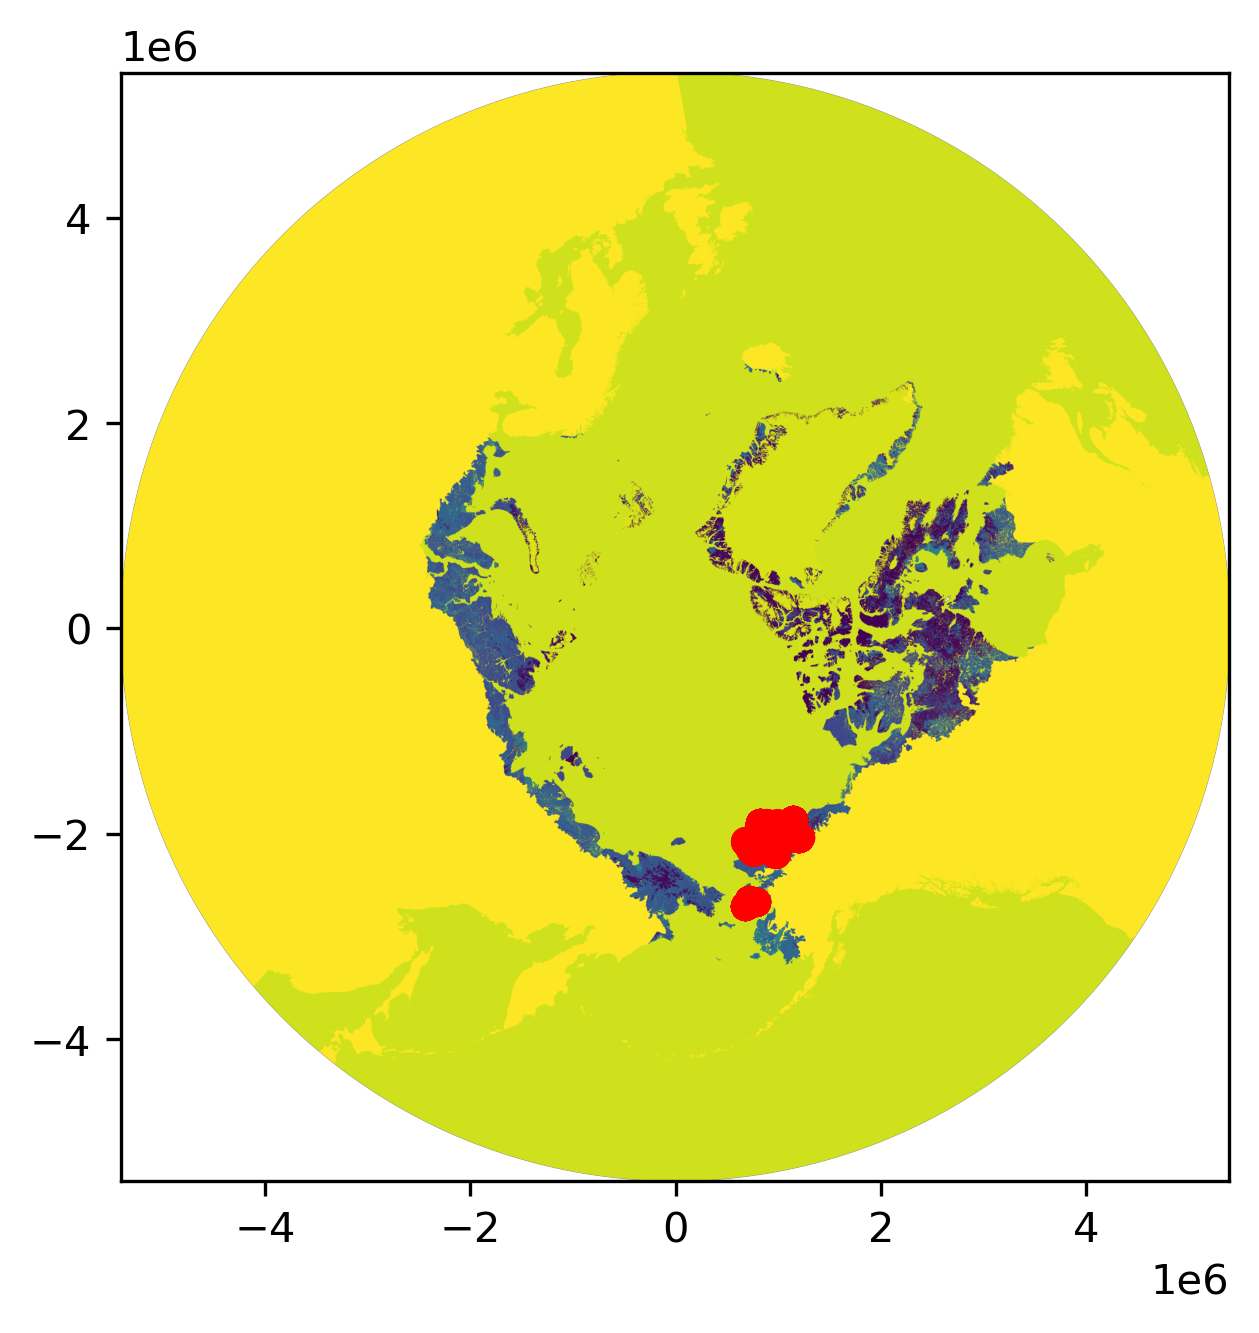

In [64]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [gdf.total_bounds[0], gdf.total_bounds[2], gdf.total_bounds[1], gdf.total_bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax)

gdf.plot(ax=ax, color='red')

In [65]:
# sample raster at coordinates
coord_list = [(x, y) for x, y in zip(gdf['geometry'].x, gdf['geometry'].y)]
gdf['raster_value'] = [x[0] for x in src.sample(coord_list)]

In [66]:
gdf.columns

Index(['visit_id', 'survey_year', 'survey_month', 'survey_day', 'plot_area',
       'plot_shape', 'latitude_y', 'longitude_x', 'georef_source',
       'georef_accuracy', 'coord_epsg', 'plot_name', 'data_subsource',
       'data_source', 'data_source_html', 'data_subsource_citation',
       'survey_method', 'fcover_scale', 'survey_purpose', 'admin_unit',
       'admin_country', 'fire_years', 'bioclim_subzone', 'duplicated_coords',
       'duplicated_date', 'cavm_unit', 'cavm_unit_description', 'geometry',
       'raster_value'],
      dtype='object')

---
## Show intersection of plot data with CAVM Zones

In [67]:
# Load the raster legend CSV
legend_path = 'etc/cavm_raster/raster_cavm_legend.csv'
legend_df = pd.read_csv(legend_path)

if 'cavm_unit' not in gdf.columns.to_list():
    
    # Ensure that 'cavm_zone' in aux_gdf and 'Raster code' in legend_df are of the same type
    gdf['raster_value'] = gdf['raster_value'].astype(str)  # Adjust type as necessary
    legend_df['Raster code'] = legend_df['Raster code'].astype(str)  # Adjust type as necessary

    # Perform the left join
    new_aux_table = gdf.merge(legend_df, left_on='raster_value', right_on='Raster code', how='left')
    new_aux_table.drop(columns=['raster_value', 'Raster code', '# Pixels', 'Area  (1000 km2)', 'Long Description', 'geometry'], inplace=True)
    new_aux_table.rename(columns={'Vegetation Unit':'cavm_unit', 'Short Description':'cavm_unit_description'}, inplace=True)
    new_aux_table = new_aux_table.set_index('visit_id')
    new_aux_table.to_csv('survey_unit_information.csv', index=True)
else:
    print('cavm_unit already present in auxiliary table.')

cavm_unit already present in auxiliary table.


In [68]:
# extract
new_aux_table = pd.read_csv('survey_unit_information.csv', index_col=0)
cavm_info = new_aux_table[['cavm_unit', 'cavm_unit_description']]
pft_cavm = pft_fcover.merge(cavm_info, left_index=True, right_index=True, how='left')

In [69]:
import xml.etree.ElementTree as ET
import re

# Path to your QML file
qml_file = 'etc/cavm_raster/cavm_colors.qml'

# Parse the XML
tree = ET.parse(qml_file)
root = tree.getroot()

# Locate the color palette entries
palette_entries = []
for palette_entry in root.findall(".//colorPalette/paletteEntry"):
    value = palette_entry.get('value')
    color = palette_entry.get('color')
    alpha = palette_entry.get('alpha')
    label = palette_entry.get('label')
    
    # Remove the " -- text" part from the label
    cleaned_label = re.sub(r' -.*', '', label)
    
    palette_entries.append({
        'value': value,
        'color': color,
        'alpha': alpha,
        'label': cleaned_label
    })

# Display the cleaned data
for entry in palette_entries:
    print(f"Value: {entry['value']}, Color: {entry['color']}, Alpha: {entry['alpha']}, Label: {entry['label']}")

Value: 1, Color: #d7d7b3, Alpha: 178, Label: B1
Value: 2, Color: #a8a802, Alpha: 178, Label: B2a
Value: 3, Color: #a68282, Alpha: 178, Label: B3
Value: 4, Color: #8282a0, Alpha: 178, Label: B4
Value: 5, Color: #cdcd66, Alpha: 178, Label: B2b
Value: 21, Color: #ffebaf, Alpha: 178, Label: G1
Value: 22, Color: #ffd37f, Alpha: 178, Label: G2
Value: 23, Color: #e6e600, Alpha: 178, Label: G3
Value: 24, Color: #ffff00, Alpha: 178, Label: G4
Value: 31, Color: #dfb0b0, Alpha: 178, Label: P1
Value: 32, Color: #db949e, Alpha: 178, Label: P2
Value: 33, Color: #97e602, Alpha: 178, Label: S1
Value: 34, Color: #38a802, Alpha: 178, Label: S2
Value: 41, Color: #9eedbd, Alpha: 178, Label: W1
Value: 42, Color: #73ffdf, Alpha: 178, Label: W2
Value: 43, Color: #04e6a9, Alpha: 178, Label: W3
Value: 91, Color: #0070ff, Alpha: 178, Label: FW
Value: 92, Color: #e0f2ff, Alpha: 178, Label: SW
Value: 93, Color: #ffffff, Alpha: 178, Label: GL
Value: 99, Color: #cccccc, Alpha: 178, Label: NA


In [70]:
palette_entries

[{'value': '1', 'color': '#d7d7b3', 'alpha': '178', 'label': 'B1'},
 {'value': '2', 'color': '#a8a802', 'alpha': '178', 'label': 'B2a'},
 {'value': '3', 'color': '#a68282', 'alpha': '178', 'label': 'B3'},
 {'value': '4', 'color': '#8282a0', 'alpha': '178', 'label': 'B4'},
 {'value': '5', 'color': '#cdcd66', 'alpha': '178', 'label': 'B2b'},
 {'value': '21', 'color': '#ffebaf', 'alpha': '178', 'label': 'G1'},
 {'value': '22', 'color': '#ffd37f', 'alpha': '178', 'label': 'G2'},
 {'value': '23', 'color': '#e6e600', 'alpha': '178', 'label': 'G3'},
 {'value': '24', 'color': '#ffff00', 'alpha': '178', 'label': 'G4'},
 {'value': '31', 'color': '#dfb0b0', 'alpha': '178', 'label': 'P1'},
 {'value': '32', 'color': '#db949e', 'alpha': '178', 'label': 'P2'},
 {'value': '33', 'color': '#97e602', 'alpha': '178', 'label': 'S1'},
 {'value': '34', 'color': '#38a802', 'alpha': '178', 'label': 'S2'},
 {'value': '41', 'color': '#9eedbd', 'alpha': '178', 'label': 'W1'},
 {'value': '42', 'color': '#73ffdf', 

/tmp/ipykernel_49799/1415996840.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G4', 'W2', 'G3', 'W2', 'W2', ..., 'S1', 'S1', 'S1', 'S1', 'S1']
Length: 977
Categories (11, object): ['SW' < 'FW' < 'W3' < 'W2' ... 'P1' < 'G4' < 'G3' < 'B1']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  current_data.loc[:, 'cavm_unit'] = pd.Categorical(current_data['cavm_unit'],
/tmp/ipykernel_49799/1415996840.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['G4', 'W2', 'G3', 'W2', 'W2', ..., 'S1', 'S1', 'S1', 'S1', 'S1']
Length: 977
Categories (11, object): ['SW' < 'FW' < 'W3' < 'W2' ... 'P1' < 'G4' < 'G3' < 'B1']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  current_data.loc[:, 'cavm_unit'] = pd.Categorical(current_data['cavm_unit'],
/tmp/ipykernel_49799/141

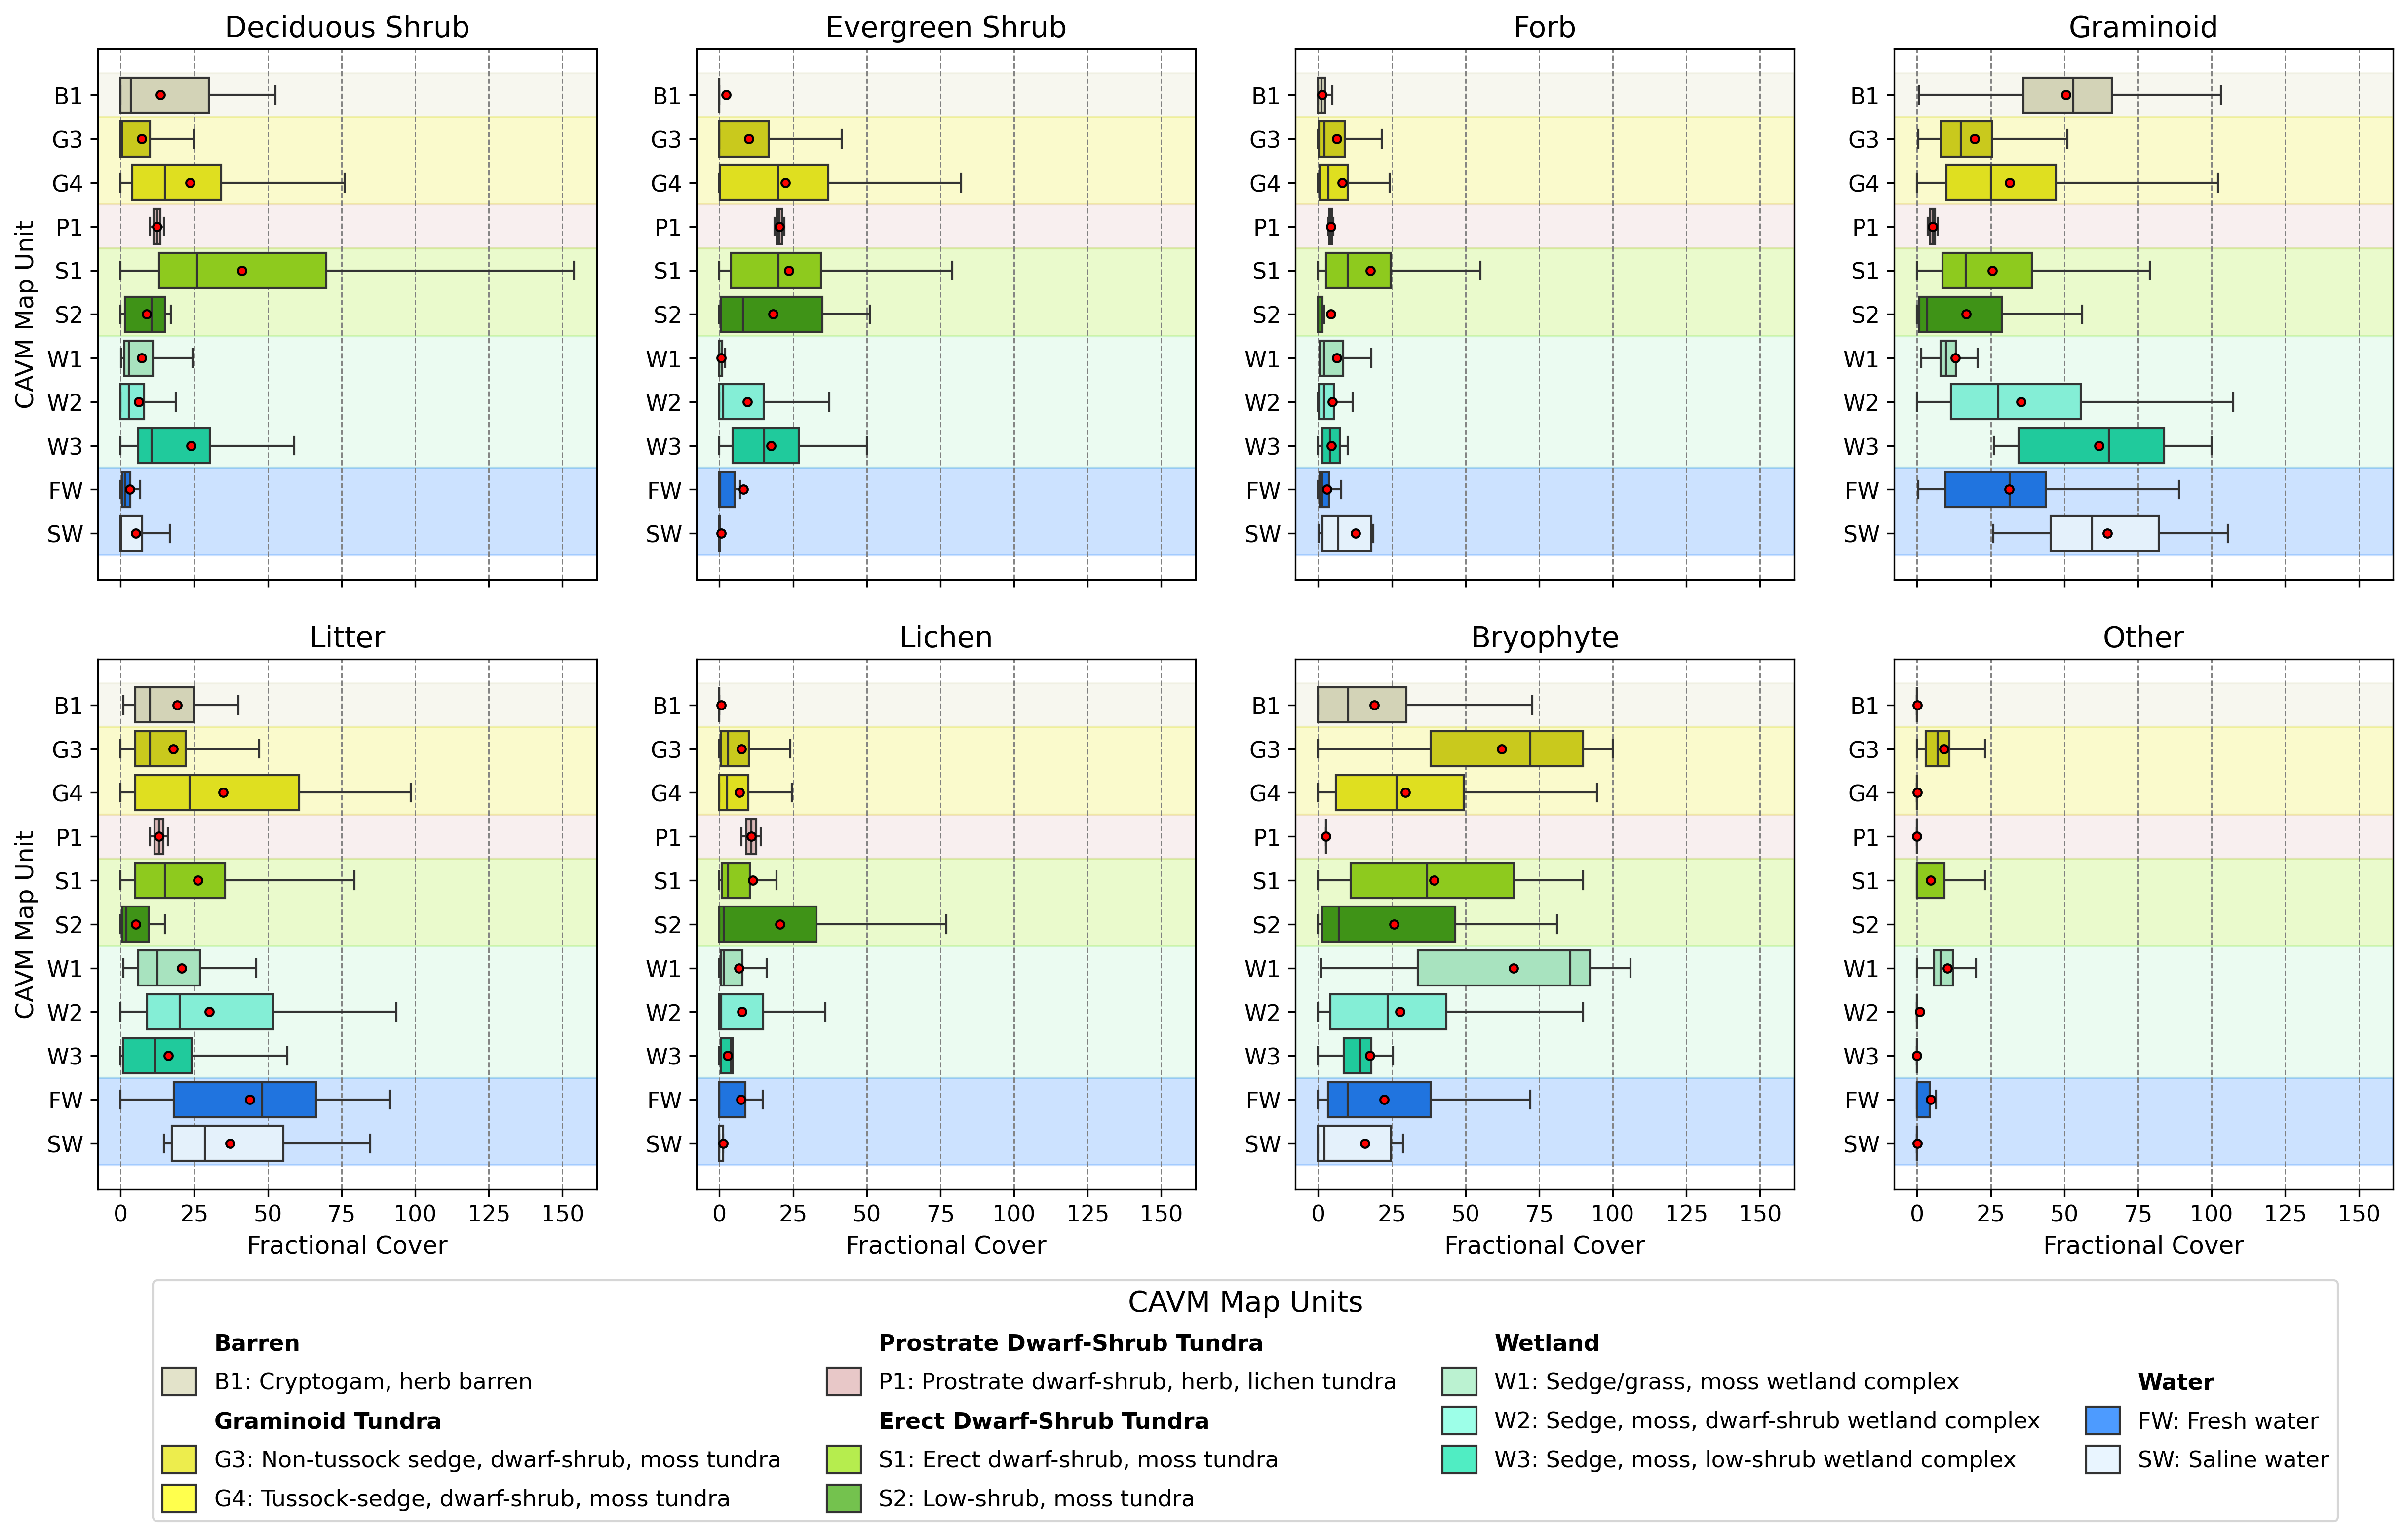

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import pandas as pd

# Define the cover types to plot
cover_types = [
    'deciduous_shrub_cover',
    'evergreen_shrub_cover',
    'forb_cover',
    'graminoid_cover',
    'litter_cover',
    'lichen_cover',
    'bryophyte_cover',
    'other_cover'
]

# Melt the DataFrame to long format
melted_pft = pft_cavm.melt(id_vars=['cavm_unit', 'cavm_unit_description'], 
                            value_vars=cover_types,
                            var_name='Cover Type', 
                            value_name='Fractional Cover')

# Get unique vegetation units and their descriptions
veg_unit_info = pft_cavm[['cavm_unit', 'cavm_unit_description']].drop_duplicates()

# Create the color map from palette_entries
color_map = {}
for entry in palette_entries:
    color = entry['color']
    alpha = int(entry['alpha']) / 255  # Convert alpha from 0-255 to 0-1
    rgba_color = mcolors.hex2color(color) + (alpha,)  # Convert hex to RGBA
    color_map[entry['label']] = rgba_color

# Define custom sorting for y-axis based on the categories (B, G, P, S, W)
category_order = ['B', 'G', 'P', 'S', 'W']

# Create a custom map for cavm_unit values to categories
unit_category_map = {
    'B1': 'B', 'B2a': 'B', 'B3': 'B', 'B4': 'B', 'B2b': 'B',
    'G1': 'G', 'G2': 'G', 'G3': 'G', 'G4': 'G',
    'P1': 'P', 'P2': 'P',
    'S1': 'S', 'S2': 'S',
    'W1': 'W', 'W2': 'W', 'W3': 'W',
    'FW': 'W', 'SW': 'W', 'GL': 'W', 'NA': 'W'
}

# Add a new column for category in melted_pft
melted_pft['Category'] = melted_pft['cavm_unit'].map(unit_category_map)

# Convert 'cavm_unit' to categorical type to ensure ordering
melted_pft['cavm_unit'] = pd.Categorical(melted_pft['cavm_unit'],
                                           categories=[unit for unit in unit_category_map if unit_category_map[unit] in category_order],
                                           ordered=True)

# Set up the number of columns for the subplot grid
num_cols = 4  # Adjusting for 2 rows of 4 columns
num_units = len(cover_types)
num_rows = int(np.ceil(num_units / num_cols))

# Set up the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

fill_regions = [('B1','B1'),
                ('G3','G4'),
                ('P1','P1'),
                ('S1','S2'),
                ('W1','W3'),
                ('FW','SW')]

# Apply fill based on regions
for i, (ax, cover_type) in enumerate(zip(axes, cover_types)):
    title = cover_type.replace('_', ' ').replace(' cover', '').title()
    
    current_data = melted_pft[melted_pft['Cover Type'] == cover_type].copy()
    units_with_data = current_data['cavm_unit'].unique()
    filtered_unit_category_map = {unit: category for unit, category in unit_category_map.items() if unit in units_with_data}
    
    current_data.loc[:, 'cavm_unit'] = pd.Categorical(current_data['cavm_unit'],
                                                       categories=[unit for unit in filtered_unit_category_map if filtered_unit_category_map[unit] in category_order][::-1],
                                                       ordered=True)
    
    sns.boxplot(
        data=current_data,
        x='Fractional Cover',
        y='cavm_unit',
        hue='cavm_unit',
        ax=ax,
        palette=color_map,
        dodge=False,
        showfliers=False,
        showmeans=True, 
        meanprops={'marker':'o',
                   'markerfacecolor':'red',
                   'markeredgecolor':'black',
                   'markersize':'4'}
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fractional Cover', fontsize=12)
    
    if i % num_cols == 0:
        ax.set_ylabel('CAVM Map Unit', fontsize=12)
    else:
        ax.set_ylabel('')
    
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')

    # Loop through each defined region to apply non-overlapping shading
    for start_unit, end_unit in fill_regions:
        start_pos = current_data['cavm_unit'].cat.categories.get_loc(start_unit) + 0.5
        end_pos = current_data['cavm_unit'].cat.categories.get_loc(end_unit) - 0.5

        color = color_map[start_unit]
        
        # Apply the shading without overlap
        ax.axhspan(
            ymin=end_pos, ymax=start_pos,  # Corrected start and end
            color=color,
            alpha=0.2  # Set alpha for subtle shading
        )
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.invert_yaxis()

# Adjust space around the subplots
plt.subplots_adjust(hspace=0.15)  # Decrease hspace to bring rows closer together

# Create a custom legend with sorted handles and dark grey borders
# Sort the handles based on the y-axis order
ordered_units = melted_pft['cavm_unit'].cat.categories
units_in_graph = current_data['cavm_unit'].unique()

# Create the legend handles with adjusted column distribution
sections = {
    'Barren': ['B1'],
    'Graminoid Tundra': ['G3', 'G4'],
    'Prostrate Dwarf-Shrub Tundra': ['P1'],
    'Erect Dwarf-Shrub Tundra': ['S1', 'S2'],
    'Wetland': ['W1', 'W2', 'W3'],
    'Water': ['FW', 'SW']
}

# Create legend handles and their corresponding labels
handles = []
for section, units in sections.items():
    # Create a dummy patch for the section title with bold label
    section_title_patch = mpatches.Patch(
        facecolor='none',  # Make section title "empty"
        edgecolor='none',  # No border for the title
        label=f'{section}',  # Set the section title as the label
    )
    handles.append(section_title_patch)  # Add the section title to the handles list
    
    # Add the unit legend handles below the section title
    for unit in units:
        # Check if the unit exists in veg_unit_info
        unit_description = veg_unit_info[veg_unit_info['cavm_unit'] == unit]['cavm_unit_description']
        
        if not unit_description.empty:
            description = unit_description.values[0]
        else:
            description = "Description not available"  # Fallback description
        
        # Create the patch (legend item) for this unit
        handles.append(
            mpatches.Patch(
                facecolor=color_map[unit],  # Use facecolor instead of color
                label=f"{unit}: {description}",
                edgecolor='#333333',  # Dark grey border around the color box
                linewidth=1  # Set border width
            )
        )

    # Add dummy patches to align legend items in columns
    if section == 'Wetland':  # Needs 1 dummy item
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))
    elif section == 'Other':
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))

# Create the legend with sections and unit handles
plt.legend(
    handles=handles,
    title='CAVM Map Units',
    bbox_to_anchor=(-1.3, -0.15),
    loc='upper center',
    ncol=4,
    fontsize=11,  # Font size for legend items
    title_fontsize=14,  # Font size for the legend title
    handlelength=1.5,  # Adjust handle length for better spacing
    handleheight=1.5,  # Adjust handle height
)

# Customize the section titles to be bold
for label in plt.gca().get_legend().get_texts():
    if label.get_text() in sections:  # Check if the label is a section title
        label.set_fontweight('bold')  # Set the section title to bold

# Hide any unused axes
for i in range(len(cover_types), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()